<a href="https://colab.research.google.com/github/parthsdoshi/nn-lenet5-cifar100/blob/master/lenet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torchvision as tv
import torch.optim as O

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
Tesla K80


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [0]:
# flattens so we can go from conv layers to linear layers
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [0]:
def createLenet5(in_channels=3, init_padding=(0, 0), classes=10, activation=nn.ReLU):
    lenet5 = nn.Sequential(
        nn.Conv2d(in_channels, 6, kernel_size=(5, 5), padding=init_padding),
        activation(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
        nn.Conv2d(6, 16, kernel_size=(5, 5)),
        activation(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
        Flatten(),
        nn.Linear(16*5*5, 120),
        activation(),
        nn.Linear(120, 84),
        activation(),
        nn.Linear(84, classes)
    )

    return lenet5

In [0]:
mnist = tv.datasets.MNIST
cifar100 = tv.datasets.CIFAR100

In [0]:
train_batch = 1
test_batch = 1000

In [0]:
mnist_train_loader = torch.utils.data.DataLoader(mnist('./mnist/train', train=True, download=True,
                                                           transform=tv.transforms.Compose([
                                                               tv.transforms.ToTensor()
                                                           ])), batch_size=train_batch, shuffle=True)
mnist_train_test_loader = torch.utils.data.DataLoader(mnist('./mnist/train', train=True, download=True,
                                                           transform=tv.transforms.Compose([
                                                               tv.transforms.ToTensor()
                                                           ])), batch_size=test_batch, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist('./mnist/test', train=False, download=True,
                                                           transform=tv.transforms.Compose([
                                                               tv.transforms.ToTensor()
                                                           ])), batch_size=test_batch, shuffle=True)

In [9]:
# looks like our datasets are stored in /content
!cat /content/sample_data/README.md

This directory includes a few sample datasets to get you started.

* `california_housing_data*.csv` is California housing data from the 1990 US
  Census; more information is available at:
  https://developers.google.com/machine-learning/crash-course/california-housing-data-description

* `mnist_*.csv` is a small sample of the [MNIST
  database](https://en.wikipedia.org/wiki/MNIST_database), which is described
  at: http://yann.lecun.com/exdb/mnist/

* `anscombe.json` contains a copy of [Anscombe's
 quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet);
  it was originally described in

      Anscombe, F. J. (1973). 'Graphs in Statistical Analysis'. American Statistician. 27 (1): 17-21. JSTOR 2682899.

  and our copy was prepared by the [vega_datasets library](https://github.com/altair-viz/vega_datasets/blob/4f67bdaad10f45e3549984e17e1b3088c731503d/vega_datasets/_data/anscombe.json).


In [10]:
print("mnist")
print(f"train size: {len(mnist_train_loader) * train_batch}\ttest size: {len(mnist_test_loader) * test_batch}")

mnist
train size: 60000	test size: 10000


In [0]:
fc_mnist = nn.Sequential(
    nn.Linear(28*28, 16),
    nn.Sigmoid(),
    nn.Linear(16, 16),
    nn.Sigmoid(),
    nn.Linear(16, 10)
)

In [0]:
lenet5_mnist = createLenet5(in_channels=1, init_padding=(2,2), classes=10)

In [13]:
print(fc_mnist)
print(lenet5_mnist)

Sequential(
  (0): Linear(in_features=784, out_features=16, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=16, out_features=10, bias=True)
)
Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)


In [0]:
# t is of dims N * 1 where N is the batch size
# C should be the number of values for the column
def oneHotEncodeOneCol(t, C=2):
    N = t.shape[0]
    onehot = torch.Tensor([
        [0] * C
    ] * N)
    for i, v in enumerate(t):
        onehot[i, v] = 1
    
    return onehot

In [0]:
validate_every = 2000

In [16]:
fc_mnist_dev = fc_mnist.to(device)
opt = O.SGD(fc_mnist_dev.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(reduction="mean")
train_cross_entropy = []
train_accuracy = []
validation_cross_entropy = []
validation_accuracy = []

best_model_accuracy = 0

for epoch in range(2):
    n_correct = 0
    n_total = 0
    for i, batch in enumerate(mnist_train_loader):
        x, labels = batch
        x, labels = x.to(device), labels.to(device)
        N = x.shape[0]
        
        x = x.view(N, -1)
        
        # training mode (for things like dropout)
        fc_mnist_dev.train()
        
        # clear previous gradients
        opt.zero_grad()
        
        y_hat = fc_mnist_dev(x)
        loss = criterion(y_hat, labels)
        loss.backward()
        opt.step()
        
        train_cross_entropy.append(loss)
        
        n_correct += (torch.argmax(y_hat, dim=1) == labels).sum().item()
        n_total += N
        
        # evaluation mode (e.g. adds dropped neurons back in)
        fc_mnist_dev.eval()
        if i % validate_every == 0:
            n_val_correct = 0
            n_val_total = 0
            v_cross_entropy_sum = 0
            
            # don't calculate gradients here
            with torch.no_grad():
                for j, v_batch in enumerate(mnist_test_loader):
                    v_x, v_labels = v_batch
                    v_x, v_labels = v_x.to(device), v_labels.to(device)
                    v_N = v_x.shape[0]
                    v_x = v_x.view(v_N, -1)
                    
                    v_y_hat = fc_mnist_dev(v_x)
                    v_loss = criterion(v_y_hat, v_labels)
                    v_cross_entropy_sum += v_loss
                    n_val_correct += (torch.argmax(v_y_hat, dim=1) == v_labels).sum().item()
                    n_val_total += v_N

            print(f"[epoch {epoch + 1}, iteration {i}] \t accuracy: {n_val_correct / n_val_total} \t cross entropy: {v_cross_entropy_sum / n_val_total}")
            validation_accuracy.append(n_val_correct / n_val_total)
            validation_cross_entropy.append(v_cross_entropy_sum / n_val_total)
            if n_val_correct / n_val_total >= best_model_accuracy:
                best_model_accuracy = n_val_correct / n_val_total
                print("saving")
                torch.save(fc_mnist_dev.state_dict(), './fc_mnist')
    
    print(f"epoch {epoch + 1} accumulated train accuracy: {n_correct / n_total}")
    train_accuracy.append(n_correct / n_total)

[epoch 1, iteration 0] 	 accuracy: 0.0892 	 cross entropy: 0.002423797966912389
saving
[epoch 1, iteration 2000] 	 accuracy: 0.1135 	 cross entropy: 0.002301551168784499
saving
[epoch 1, iteration 4000] 	 accuracy: 0.181 	 cross entropy: 0.0022899473551660776
saving
[epoch 1, iteration 6000] 	 accuracy: 0.3715 	 cross entropy: 0.002164327073842287
saving
[epoch 1, iteration 8000] 	 accuracy: 0.3879 	 cross entropy: 0.0018770139431580901
saving
[epoch 1, iteration 10000] 	 accuracy: 0.5244 	 cross entropy: 0.001557467388920486
saving
[epoch 1, iteration 12000] 	 accuracy: 0.598 	 cross entropy: 0.0013382525648921728
saving
[epoch 1, iteration 14000] 	 accuracy: 0.6803 	 cross entropy: 0.0011474546045064926
saving
[epoch 1, iteration 16000] 	 accuracy: 0.7337 	 cross entropy: 0.0010023124050348997
saving
[epoch 1, iteration 18000] 	 accuracy: 0.7665 	 cross entropy: 0.0008967500180006027
saving
[epoch 1, iteration 20000] 	 accuracy: 0.7745 	 cross entropy: 0.0008305091760121286
saving
[e

In [0]:
fc_train_cross_entropy = train_cross_entropy
fc_train_accuracy = train_accuracy
fc_validation_cross_entropy = validation_cross_entropy
fc_validation_accuracy = validation_accuracy

In [18]:
lenet5_mnist_dev = lenet5_mnist.to(device)
opt = O.SGD(lenet5_mnist_dev.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(reduction="mean")
train_cross_entropy = []
train_accuracy = []
validation_cross_entropy = []
validation_accuracy = []

best_model_accuracy = 0

for epoch in range(2):
    n_correct = 0
    n_total = 0
    for i, batch in enumerate(mnist_train_loader):
        x, labels = batch
        x, labels = x.to(device), labels.to(device)
        N = x.shape[0]
        
        # training mode (for things like dropout)
        lenet5_mnist_dev.train()
        
        # clear previous gradients
        opt.zero_grad()
        
        y_hat = lenet5_mnist_dev(x)
        loss = criterion(y_hat, labels)
        loss.backward()
        opt.step()
        
        train_cross_entropy.append(loss)
        
        n_correct += (torch.argmax(y_hat, dim=1) == labels).sum().item()
        n_total += N
        
        # evaluation mode (e.g. adds dropped neurons back in)
        lenet5_mnist_dev.eval()
        if i % validate_every == 0:
            n_val_correct = 0
            n_val_total = 0
            v_cross_entropy_sum = 0
            
            # don't calculate gradients here
            with torch.no_grad():
                for j, v_batch in enumerate(mnist_test_loader):
                    v_x, v_labels = v_batch
                    v_x, v_labels = v_x.to(device), v_labels.to(device)
                    v_N = v_x.shape[0]
                    
                    v_y_hat = lenet5_mnist_dev(v_x)
                    v_loss = criterion(v_y_hat, v_labels)
                    v_cross_entropy_sum += v_loss
                    n_val_correct += (torch.argmax(v_y_hat, dim=1) == v_labels).sum().item()
                    n_val_total += v_N

            print(f"[epoch {epoch + 1}, iteration {i}] \t accuracy: {n_val_correct / n_val_total} \t cross entropy: {v_cross_entropy_sum / n_val_total}")
            validation_accuracy.append(n_val_correct / n_val_total)
            validation_cross_entropy.append(v_cross_entropy_sum / n_val_total)
            if n_val_correct / n_val_total >= best_model_accuracy:
                best_model_accuracy = n_val_correct / n_val_total
                print("saving")
                torch.save(lenet5_mnist_dev.state_dict(), './lenet5_mnist')
    
    print(f"epoch {epoch + 1} accumulated train accuracy: {n_correct / n_total}")
    train_accuracy.append(n_correct / n_total)

[epoch 1, iteration 0] 	 accuracy: 0.111 	 cross entropy: 0.002304749097675085
saving
[epoch 1, iteration 2000] 	 accuracy: 0.6454 	 cross entropy: 0.0010980804217979312
saving
[epoch 1, iteration 4000] 	 accuracy: 0.9057 	 cross entropy: 0.0003122975758742541
saving
[epoch 1, iteration 6000] 	 accuracy: 0.9305 	 cross entropy: 0.00022383779287338257
saving
[epoch 1, iteration 8000] 	 accuracy: 0.9282 	 cross entropy: 0.00021841167472302914
[epoch 1, iteration 10000] 	 accuracy: 0.9543 	 cross entropy: 0.00014112141798250377
saving
[epoch 1, iteration 12000] 	 accuracy: 0.9287 	 cross entropy: 0.0002348856214666739
[epoch 1, iteration 14000] 	 accuracy: 0.9628 	 cross entropy: 0.00011924622958758846
saving
[epoch 1, iteration 16000] 	 accuracy: 0.9624 	 cross entropy: 0.0001337506400886923
[epoch 1, iteration 18000] 	 accuracy: 0.9663 	 cross entropy: 0.00011331064160913229
saving
[epoch 1, iteration 20000] 	 accuracy: 0.9736 	 cross entropy: 8.813772001303732e-05
saving
[epoch 1, iter

In [0]:
l5_mnist_train_cross_entropy = train_cross_entropy
l5_mnist_train_accuracy = train_accuracy
l5_mnist_validation_cross_entropy = validation_cross_entropy
l5_mnist_validation_accuracy = validation_accuracy

In [0]:
import matplotlib.pyplot as plt
import numpy as np

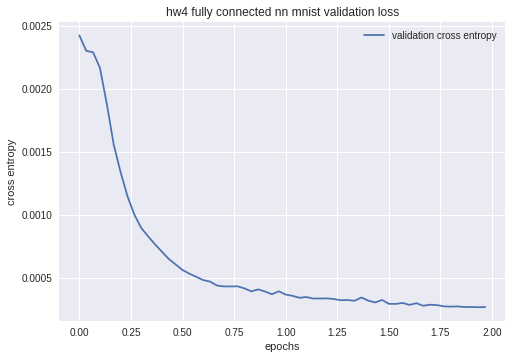

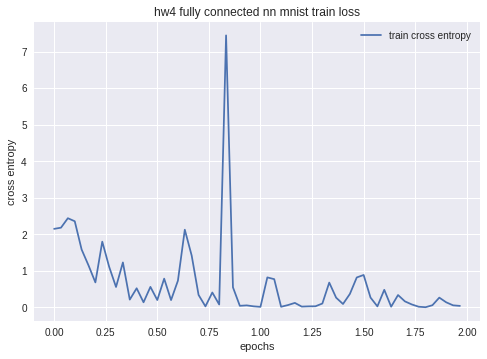

In [54]:
# fc_train_cross_entropy = train_cross_entropy
# fc_train_accuracy = train_accuracy
# fc_validation_cross_entropy = validation_cross_entropy
# fc_validation_accuracy = validation_accuracy

fc_y = np.array(fc_train_cross_entropy)[0::2000]
fc_y.shape
fc_y_test = np.array(fc_validation_cross_entropy)
fc_y_test.shape
x = np.array(list(range(0, 120000, 2000)))
x = x / 60000
x
plt.plot(x, fc_y_test, label='validation cross entropy')
plt.xlabel('epochs')
plt.ylabel('cross entropy')
plt.title('hw4 fully connected nn mnist validation loss')
plt.legend()
plt.show()

plt.plot(x, fc_y, label='train cross entropy')
plt.xlabel('epochs')
plt.ylabel('cross entropy')
plt.title('hw4 fully connected nn mnist train loss')
plt.legend()
plt.show()
# 2000*60
# len(mnist_train_loader)

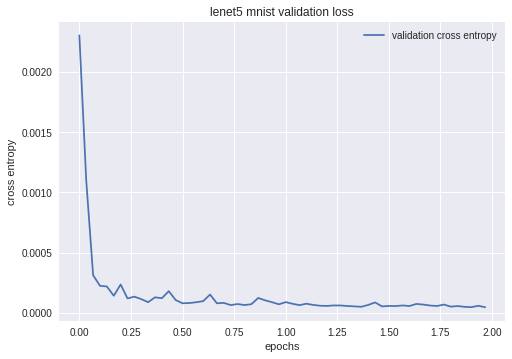

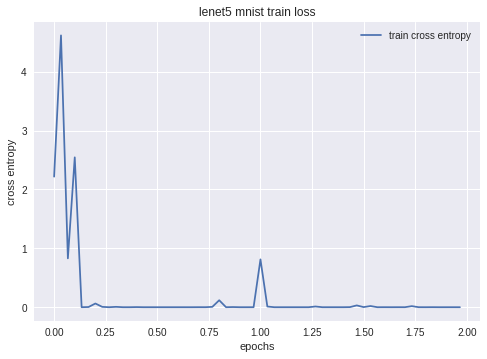

In [53]:
l5_y = np.array(l5_mnist_train_cross_entropy)[0::2000]
l5_y.shape
l5_y_test = np.array(l5_mnist_validation_cross_entropy)
l5_y_test.shape
x = np.array(list(range(0, 120000, 2000)))
x = x / 60000
x
plt.plot(x, l5_y_test, label='validation cross entropy')
plt.xlabel('epochs')
plt.ylabel('cross entropy')
plt.title('lenet5 mnist validation loss')
plt.legend()
plt.show()

plt.plot(x, l5_y, label='train cross entropy')
plt.xlabel('epochs')
plt.ylabel('cross entropy')
plt.title('lenet5 mnist train loss')
plt.legend()
plt.show()
# 2000*60
# len(mnist_train_loader)

In [0]:
import time

In [35]:
for x, y in mnist_test_loader:
    x = x.to(device)
    
    t = time.process_time()
    lenet5_mnist_dev.forward(x)
    elapsed_time = time.process_time() - t
    print(elapsed_time)
    
    N = x.shape[0]
    x = x.view(N, -1)
    
    t = time.process_time()
    fc_mnist_dev.forward(x)
    elapsed_time = time.process_time() - t
    print(elapsed_time)
    
    break

0.0011160639999161504
0.00030915099989670125


In [20]:
cifar100_train_loader = torch.utils.data.DataLoader(cifar100('./cifar100/train', train=True, download=True,
                                                           transform=tv.transforms.Compose([
                                                               tv.transforms.ToTensor()
                                                           ])), batch_size=64, shuffle=True)
cifar100_train_test_loader = torch.utils.data.DataLoader(cifar100('./cifar100/train', train=True, download=True,
                                                           transform=tv.transforms.Compose([
                                                               tv.transforms.ToTensor()
                                                           ])), batch_size=test_batch, shuffle=True)
cifar100_test_loader = torch.utils.data.DataLoader(cifar100('./cifar100/test', train=False, download=True,
                                                           transform=tv.transforms.Compose([
                                                               tv.transforms.ToTensor()
                                                           ])), batch_size=test_batch, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [21]:
print("cifar100")
print(f"train size: {len(cifar100_train_loader) * train_batch}\ttest size: {len(cifar100_test_loader) * test_batch}")

cifar100
train size: 782	test size: 10000


In [0]:
lenet5_cifar100 = createLenet5(in_channels=3, classes=100)

In [23]:
lenet5_cifar100_dev = lenet5_cifar100.to(device)
opt = O.Adam(lenet5_cifar100_dev.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction="mean")
train_cross_entropy = []
train_accuracy = []
validation_cross_entropy = []
validation_accuracy = []

best_model_accuracy = 0

for epoch in range(50):
    n_correct = 0
    n_total = 0
    for i, batch in enumerate(cifar100_train_loader):
        x, labels = batch
        x, labels = x.to(device), labels.to(device)
        N = x.shape[0]
        
        # training mode (for things like dropout)
        lenet5_cifar100_dev.train()
        
        # clear previous gradients
        opt.zero_grad()
        
        y_hat = lenet5_cifar100_dev(x)
        loss = criterion(y_hat, labels)
        loss.backward()
        opt.step()
        
        train_cross_entropy.append(loss)
        
        n_correct += (torch.argmax(y_hat, dim=1) == labels).sum().item()
        n_total += N
        
        # evaluation mode (e.g. adds dropped neurons back in)
        lenet5_cifar100_dev.eval()
        if i % validate_every == 0:
            n_val_correct = 0
            n_val_total = 0
            v_cross_entropy_sum = 0
            
            # don't calculate gradients here
            with torch.no_grad():
                for j, v_batch in enumerate(cifar100_test_loader):
                    v_x, v_labels = v_batch
                    v_x, v_labels = v_x.to(device), v_labels.to(device)
                    v_N = v_x.shape[0]
                    
                    v_y_hat = lenet5_cifar100_dev(v_x)
                    v_loss = criterion(v_y_hat, v_labels)
                    v_cross_entropy_sum += v_loss
                    n_val_correct += (torch.argmax(v_y_hat, dim=1) == v_labels).sum().item()
                    n_val_total += v_N

            print(f"[epoch {epoch + 1}, iteration {i}] \t accuracy: {n_val_correct / n_val_total} \t cross entropy: {v_cross_entropy_sum / n_val_total}")
            validation_accuracy.append(n_val_correct / n_val_total)
            validation_cross_entropy.append(v_cross_entropy_sum / n_val_total)
            if n_val_correct / n_val_total >= best_model_accuracy:
                best_model_accuracy = n_val_correct / n_val_total
                print("saving")
                torch.save(lenet5_cifar100_dev.state_dict(), './lenet5_cifar100')
    
    print(f"epoch {epoch + 1} accumulated train accuracy: {n_correct / n_total}")
    train_accuracy.append(n_correct / n_total)

[epoch 1, iteration 0] 	 accuracy: 0.0119 	 cross entropy: 0.004607115872204304
saving


KeyboardInterrupt: ignored

In [0]:
net = createLenet5(3, classes=100)
net.load_state_dict(torch.load('./lenet5_cifar100'))

In [0]:
import cv2

In [0]:
for img, label in cifar100_train_loader:
    cv2.imshow('work', img.numpy())
    break